## Crypto Prediction with LSTM: BitCoin (BTC)

- This notebook attempts to use TensorFlow Keras LSTM to predict movement in Crypto prices
- Data is pulled from the CoinApi, so it can be refreshed at any point and retrained
- 2 optimizations were used and an overall R2 score of .86 was attained

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt

import nasdaqdatalink

from api_keys import coinapi_key

2023-10-08 10:37:43.396870: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#  https://docs.coinapi.io/market-data/rest-api/ohlcv
# Pull ETH data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_BTC_USD/history?period_id=1DAY&limit=20000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-10-08T00:00:00.0000000Z', 'time_period_end': '2023-10-09T00:00:00.0000000Z', 'time_open': '2023-10-08T00:00:08.1270000Z', 'time_close': '2023-10-08T14:37:46.7730000Z', 'price_open': 27976, 'price_high': 28104, 'price_low': 27715, 'price_close': 27945, 'volume_traded': 363.50396615, 'trades_count': 5050}, {'time_period_start': '2023-10-07T00:00:00.0000000Z', 'time_period_end': '2023-10-08T00:00:00.0000000Z', 'time_open': '2023-10-07T00:00:27.3530000Z', 'time_close': '2023-10-07T23:58:57.3370000Z', 'price_open': 27945, 'price_high': 28034, 'price_low': 27864, 'price_close': 27971, 'volume_traded': 350.03911387, 'trades_count': 7165}, {'time_period_start': '2023-10-06T00:00:00.0000000Z', 'time_period_end': '2023-10-07T00:00:00.0000000Z', 'time_open': '2023-10-06T00:00:07.4740000Z', 'time_close': '2023-10-06T23:59:26.5070000Z', 'price_open': 27420, 'price_high': 28301, 'price_low': 27185, 'price_close': 27948, 'volume_traded': 1689.24642577, 'trades_count': 157

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-10-08T00:00:00.0000000Z,2023-10-09T00:00:00.0000000Z,2023-10-08T00:00:08.1270000Z,2023-10-08T14:37:46.7730000Z,27976.0,28104.0,27715.0,27945.0,363.503966,5050
1,2023-10-07T00:00:00.0000000Z,2023-10-08T00:00:00.0000000Z,2023-10-07T00:00:27.3530000Z,2023-10-07T23:58:57.3370000Z,27945.0,28034.0,27864.0,27971.0,350.039114,7165
2,2023-10-06T00:00:00.0000000Z,2023-10-07T00:00:00.0000000Z,2023-10-06T00:00:07.4740000Z,2023-10-06T23:59:26.5070000Z,27420.0,28301.0,27185.0,27948.0,1689.246426,15797
3,2023-10-05T00:00:00.0000000Z,2023-10-06T00:00:00.0000000Z,2023-10-05T00:00:03.3190000Z,2023-10-05T23:59:56.5340000Z,27787.0,28125.0,27369.0,27417.0,1494.732570,11349
4,2023-10-04T00:00:00.0000000Z,2023-10-05T00:00:00.0000000Z,2023-10-04T00:00:07.4540000Z,2023-10-04T23:59:57.6530000Z,27431.0,27831.0,27221.0,27790.0,1262.330852,10892


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data.head()

,Close
Date,
2011-09-13,5.97
2011-09-14,5.53
2011-09-15,5.13
2011-09-16,4.85
2011-09-17,4.87


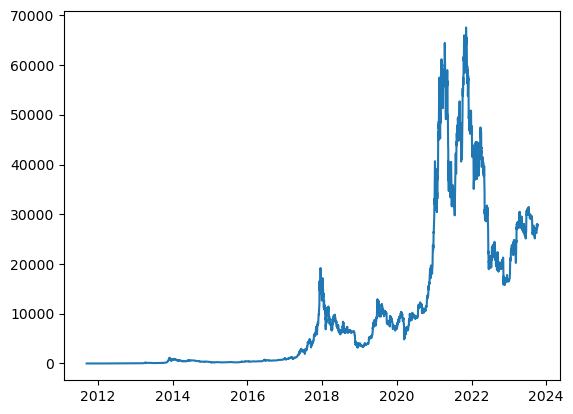

In [5]:
#plot historical amzn price
plt.plot(data)

In [6]:
# Set parameters for model

lookback = 7

split_1 = .8
split_2 = .9

In [7]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(data, lookback)

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

#Scale data
log_transformed_data = np.log(shifted_df_as_np)



# split reference from deatures
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape


((4249, 7), (4249,), (4249,))

In [8]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((3399, 7), (3399,), (425, 7), (425,), (425, 7), (425,))

In [9]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

2023-10-08 10:38:01.998642: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
107/107 [==============================] - 11s 38ms/step - loss: 10.4372 - mean_absolute_error: 2.0739 - val_loss: 0.2686 - val_mean_absolute_error: 0.4935
Epoch 2/100
107/107 [==============================] - 1s 11ms/step - loss: 0.0130 - mean_absolute_error: 0.0732 - val_loss: 0.0198 - val_mean_absolute_error: 0.1186
Epoch 3/100
107/107 [==============================] - 1s 14ms/step - loss: 0.0059 - mean_absolute_error: 0.0538 - val_loss: 0.0060 - val_mean_absolute_error: 0.0616
Epoch 4/100
107/107 [==============================] - 2s 14ms/step - loss: 0.0049 - mean_absolute_error: 0.0484 - val_loss: 0.0091 - val_mean_absolute_error: 0.0804
Epoch 5/100
107/107 [==============================] - 1s 14ms/step - loss: 0.0045 - mean_absolute_error: 0.0455 - val_loss: 0.0057 - val_mean_absolute_error: 0.0614
Epoch 6/100
107/107 [==============================] - 1s 14ms/step - loss: 0.0045 - mean_absolute_error: 0.0465 - val_loss: 0.0037 - val_mean_absolute_error: 0.0479
Ep

107/107 [==============================] - 1s 14ms/step - loss: 0.0040 - mean_absolute_error: 0.0442 - val_loss: 0.0045 - val_mean_absolute_error: 0.0581
Epoch 51/100
107/107 [==============================] - 1s 13ms/step - loss: 0.0035 - mean_absolute_error: 0.0408 - val_loss: 0.0016 - val_mean_absolute_error: 0.0302
Epoch 52/100
107/107 [==============================] - 1s 13ms/step - loss: 0.0035 - mean_absolute_error: 0.0402 - val_loss: 0.0056 - val_mean_absolute_error: 0.0653
Epoch 53/100
107/107 [==============================] - 1s 12ms/step - loss: 0.0033 - mean_absolute_error: 0.0380 - val_loss: 0.0034 - val_mean_absolute_error: 0.0495
Epoch 54/100
107/107 [==============================] - 2s 14ms/step - loss: 0.0035 - mean_absolute_error: 0.0402 - val_loss: 0.0121 - val_mean_absolute_error: 0.1032
Epoch 55/100
107/107 [==============================] - 1s 13ms/step - loss: 0.0036 - mean_absolute_error: 0.0405 - val_loss: 0.0017 - val_mean_absolute_error: 0.0306
Epoch 56/10

107/107 [==============================] - 1s 11ms/step - loss: 0.0036 - mean_absolute_error: 0.0428 - val_loss: 0.0053 - val_mean_absolute_error: 0.0654
Epoch 100/100
107/107 [==============================] - 1s 13ms/step - loss: 0.0032 - mean_absolute_error: 0.0384 - val_loss: 0.0019 - val_mean_absolute_error: 0.0343


107/107 [==============================] - 3s 6ms/step


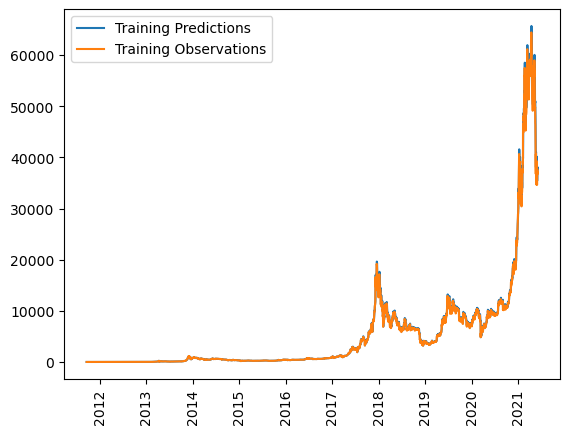

In [10]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [11]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0019438252784311771
Val MAE: 0.034285783767700195


14/14 [==============================] - 0s 5ms/step


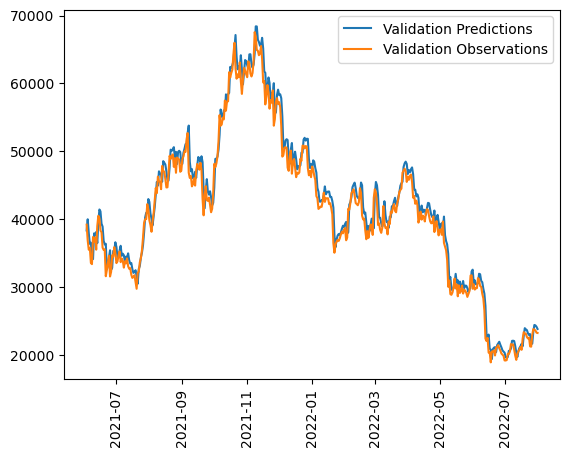

In [12]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [13]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0011529771145433187
Test MAE: 0.027530834078788757


14/14 [==============================] - 0s 4ms/step


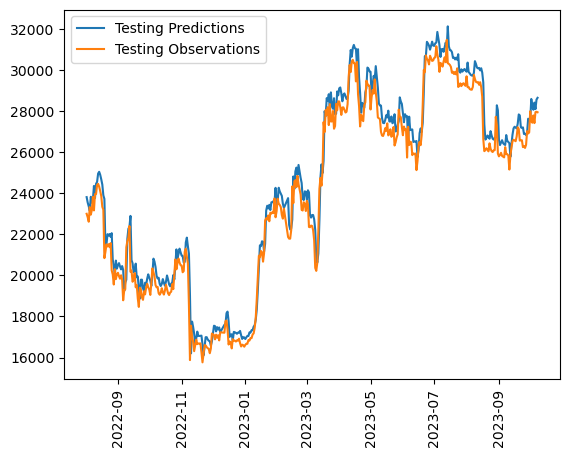

In [14]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [15]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  0.9699835159285334


## Optimization of the Model

- Adjust the initial data used, limited to the last 50% of the data
- Focus more on recent trends for learning
- Increase Epochs
- Slow learning rate

In [16]:
# Split is changed to begin at 50% of the dataset and continue to the end.
split_1 = .5
split_2 = .89
split_3 = .95


initial_split = int(len(X1) * split_1)
train_split = int(len(X1) * split_2)
test_split = int(len(X1) * split_3)

In [17]:
#change timeframe

dates_train2, X_train2, y_train2 = dates[initial_split:train_split],X1[initial_split:train_split], y1[initial_split:train_split]
dates_val2, X_val2, y_val2 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test2, X_test2, y_test2 = dates[test_split:], X1[test_split:], y1[test_split:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((1657,),
 (1657, 7),
 (1657,),
 (255,),
 (255, 7),
 (255,),
 (213,),
 (213, 7),
 (213,))

In [18]:
# Build, compile and fit the new model- increased epochs, smaller learning rate
model2 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300)

Epoch 1/300
107/107 [==============================] - 15s 36ms/step - loss: 34.2509 - mean_absolute_error: 5.3721 - val_loss: 57.2235 - val_mean_absolute_error: 7.5588
Epoch 2/300
107/107 [==============================] - 1s 12ms/step - loss: 10.0590 - mean_absolute_error: 2.5597 - val_loss: 14.9191 - val_mean_absolute_error: 3.8501
Epoch 3/300
107/107 [==============================] - 1s 13ms/step - loss: 2.0329 - mean_absolute_error: 1.2533 - val_loss: 6.9654 - val_mean_absolute_error: 2.6232
Epoch 4/300
107/107 [==============================] - 1s 13ms/step - loss: 0.8096 - mean_absolute_error: 0.7655 - val_loss: 3.3080 - val_mean_absolute_error: 1.8013
Epoch 5/300
107/107 [==============================] - 1s 13ms/step - loss: 0.2794 - mean_absolute_error: 0.4112 - val_loss: 1.3963 - val_mean_absolute_error: 1.1606
Epoch 6/300
107/107 [==============================] - 1s 13ms/step - loss: 0.0994 - mean_absolute_error: 0.2243 - val_loss: 0.6700 - val_mean_absolute_error: 0.7978

107/107 [==============================] - 2s 15ms/step - loss: 0.0040 - mean_absolute_error: 0.0403 - val_loss: 0.0029 - val_mean_absolute_error: 0.0421
Epoch 51/300
107/107 [==============================] - 2s 16ms/step - loss: 0.0039 - mean_absolute_error: 0.0404 - val_loss: 0.0029 - val_mean_absolute_error: 0.0421
Epoch 52/300
107/107 [==============================] - 2s 15ms/step - loss: 0.0040 - mean_absolute_error: 0.0414 - val_loss: 0.0034 - val_mean_absolute_error: 0.0454
Epoch 53/300
107/107 [==============================] - 2s 16ms/step - loss: 0.0040 - mean_absolute_error: 0.0414 - val_loss: 0.0034 - val_mean_absolute_error: 0.0452
Epoch 54/300
107/107 [==============================] - 2s 14ms/step - loss: 0.0041 - mean_absolute_error: 0.0414 - val_loss: 0.0028 - val_mean_absolute_error: 0.0416
Epoch 55/300
107/107 [==============================] - 2s 17ms/step - loss: 0.0039 - mean_absolute_error: 0.0407 - val_loss: 0.0057 - val_mean_absolute_error: 0.0606
Epoch 56/30

107/107 [==============================] - 2s 16ms/step - loss: 0.0034 - mean_absolute_error: 0.0377 - val_loss: 0.0025 - val_mean_absolute_error: 0.0382
Epoch 100/300
107/107 [==============================] - 2s 16ms/step - loss: 0.0034 - mean_absolute_error: 0.0385 - val_loss: 0.0023 - val_mean_absolute_error: 0.0381
Epoch 101/300
107/107 [==============================] - 1s 14ms/step - loss: 0.0034 - mean_absolute_error: 0.0383 - val_loss: 0.0025 - val_mean_absolute_error: 0.0382
Epoch 102/300
107/107 [==============================] - 2s 15ms/step - loss: 0.0033 - mean_absolute_error: 0.0371 - val_loss: 0.0022 - val_mean_absolute_error: 0.0376
Epoch 103/300
107/107 [==============================] - 2s 16ms/step - loss: 0.0033 - mean_absolute_error: 0.0370 - val_loss: 0.0029 - val_mean_absolute_error: 0.0420
Epoch 104/300
107/107 [==============================] - 1s 14ms/step - loss: 0.0033 - mean_absolute_error: 0.0370 - val_loss: 0.0023 - val_mean_absolute_error: 0.0371
Epoch 

Epoch 148/300
107/107 [==============================] - 2s 17ms/step - loss: 0.0028 - mean_absolute_error: 0.0326 - val_loss: 0.0020 - val_mean_absolute_error: 0.0338
Epoch 149/300
107/107 [==============================] - 2s 16ms/step - loss: 0.0028 - mean_absolute_error: 0.0331 - val_loss: 0.0017 - val_mean_absolute_error: 0.0312
Epoch 150/300
107/107 [==============================] - 2s 16ms/step - loss: 0.0028 - mean_absolute_error: 0.0335 - val_loss: 0.0017 - val_mean_absolute_error: 0.0323
Epoch 151/300
107/107 [==============================] - 2s 16ms/step - loss: 0.0028 - mean_absolute_error: 0.0336 - val_loss: 0.0021 - val_mean_absolute_error: 0.0352
Epoch 152/300
107/107 [==============================] - 2s 14ms/step - loss: 0.0028 - mean_absolute_error: 0.0334 - val_loss: 0.0018 - val_mean_absolute_error: 0.0316
Epoch 153/300
107/107 [==============================] - 2s 16ms/step - loss: 0.0028 - mean_absolute_error: 0.0331 - val_loss: 0.0021 - val_mean_absolute_error:

Epoch 197/300
107/107 [==============================] - 2s 19ms/step - loss: 0.0027 - mean_absolute_error: 0.0328 - val_loss: 0.0016 - val_mean_absolute_error: 0.0310
Epoch 198/300
107/107 [==============================] - 2s 18ms/step - loss: 0.0028 - mean_absolute_error: 0.0344 - val_loss: 0.0018 - val_mean_absolute_error: 0.0322
Epoch 199/300
107/107 [==============================] - 2s 18ms/step - loss: 0.0027 - mean_absolute_error: 0.0326 - val_loss: 0.0015 - val_mean_absolute_error: 0.0293
Epoch 200/300
107/107 [==============================] - 2s 17ms/step - loss: 0.0026 - mean_absolute_error: 0.0317 - val_loss: 0.0032 - val_mean_absolute_error: 0.0460
Epoch 201/300
107/107 [==============================] - 2s 16ms/step - loss: 0.0027 - mean_absolute_error: 0.0324 - val_loss: 0.0033 - val_mean_absolute_error: 0.0471
Epoch 202/300
107/107 [==============================] - 2s 19ms/step - loss: 0.0028 - mean_absolute_error: 0.0332 - val_loss: 0.0015 - val_mean_absolute_error:

Epoch 246/300
107/107 [==============================] - 2s 17ms/step - loss: 0.0027 - mean_absolute_error: 0.0338 - val_loss: 0.0019 - val_mean_absolute_error: 0.0330
Epoch 247/300
107/107 [==============================] - 2s 21ms/step - loss: 0.0026 - mean_absolute_error: 0.0317 - val_loss: 0.0015 - val_mean_absolute_error: 0.0281
Epoch 248/300
107/107 [==============================] - 2s 21ms/step - loss: 0.0026 - mean_absolute_error: 0.0319 - val_loss: 0.0015 - val_mean_absolute_error: 0.0282
Epoch 249/300
107/107 [==============================] - 2s 21ms/step - loss: 0.0026 - mean_absolute_error: 0.0328 - val_loss: 0.0022 - val_mean_absolute_error: 0.0377
Epoch 250/300
107/107 [==============================] - 2s 18ms/step - loss: 0.0027 - mean_absolute_error: 0.0330 - val_loss: 0.0041 - val_mean_absolute_error: 0.0557
Epoch 251/300
107/107 [==============================] - 2s 20ms/step - loss: 0.0026 - mean_absolute_error: 0.0320 - val_loss: 0.0022 - val_mean_absolute_error:

Epoch 295/300
107/107 [==============================] - 1s 11ms/step - loss: 0.0025 - mean_absolute_error: 0.0310 - val_loss: 0.0014 - val_mean_absolute_error: 0.0275
Epoch 296/300
107/107 [==============================] - 1s 11ms/step - loss: 0.0026 - mean_absolute_error: 0.0319 - val_loss: 0.0027 - val_mean_absolute_error: 0.0423
Epoch 297/300
107/107 [==============================] - 2s 14ms/step - loss: 0.0027 - mean_absolute_error: 0.0334 - val_loss: 0.0019 - val_mean_absolute_error: 0.0344
Epoch 298/300
107/107 [==============================] - 1s 14ms/step - loss: 0.0026 - mean_absolute_error: 0.0325 - val_loss: 0.0014 - val_mean_absolute_error: 0.0281
Epoch 299/300
107/107 [==============================] - 1s 13ms/step - loss: 0.0026 - mean_absolute_error: 0.0318 - val_loss: 0.0015 - val_mean_absolute_error: 0.0279
Epoch 300/300
107/107 [==============================] - 1s 13ms/step - loss: 0.0026 - mean_absolute_error: 0.0327 - val_loss: 0.0022 - val_mean_absolute_error:

52/52 [==============================] - 3s 7ms/step


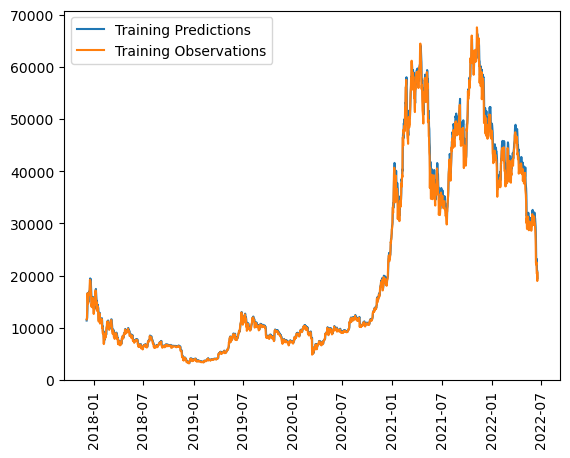

In [19]:
#Second model observations
train_predictions2 = model2.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions2))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [20]:
score = model2.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0013239035615697503
Val MAE: 0.02861778810620308


8/8 [==============================] - 0s 9ms/step


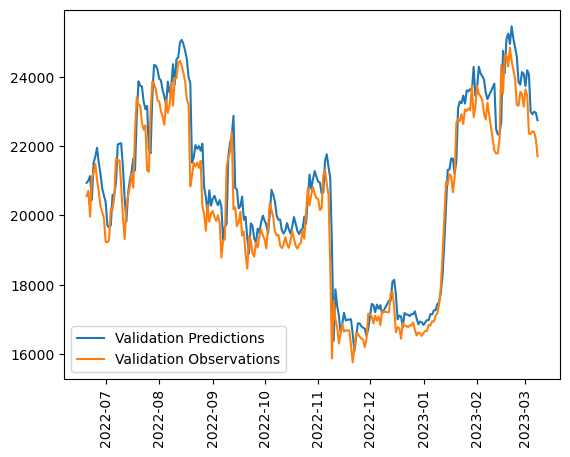

In [21]:
#Second model observations
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [22]:
#MSAE Score for second model
score = model2.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0011668822262436152
Test MAE: 0.029868103563785553


In [23]:
# R2 score for second model
y_pred = model2.predict(X_test2)
print('R2 Score: ', r2_score(y_test2, y_pred))

7/7 [==============================] - 0s 7ms/step
R2 Score:  0.761546486956576


7/7 [==============================] - 0s 6ms/step


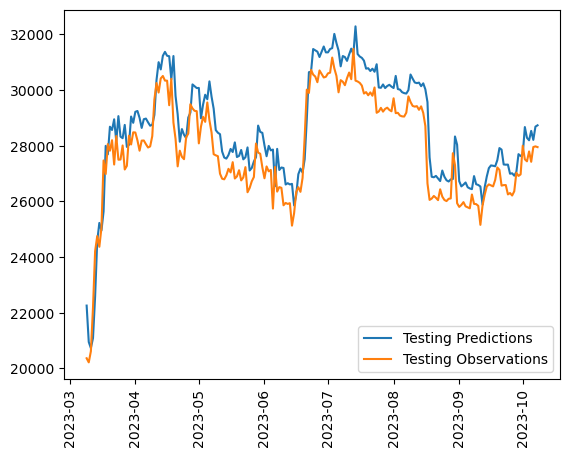

In [24]:
#Second model observations
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [42]:
# Second optimization. Increased neural density, epochs
model3 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64, return_sequences=True),
                    layers.LSTM(64, return_sequences=False),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.01),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=300)

Epoch 1/300
52/52 [==============================] - 12s 62ms/step - loss: 15.7814 - mean_absolute_error: 2.6090 - val_loss: 0.0219 - val_mean_absolute_error: 0.1287
Epoch 2/300
52/52 [==============================] - 1s 17ms/step - loss: 0.7623 - mean_absolute_error: 0.7658 - val_loss: 0.0870 - val_mean_absolute_error: 0.2684
Epoch 3/300
52/52 [==============================] - 1s 16ms/step - loss: 0.7476 - mean_absolute_error: 0.7555 - val_loss: 0.3480 - val_mean_absolute_error: 0.5771
Epoch 4/300
52/52 [==============================] - 1s 16ms/step - loss: 0.7490 - mean_absolute_error: 0.7587 - val_loss: 0.1402 - val_mean_absolute_error: 0.3540
Epoch 5/300
52/52 [==============================] - 1s 16ms/step - loss: 0.7121 - mean_absolute_error: 0.7392 - val_loss: 0.1458 - val_mean_absolute_error: 0.3666
Epoch 6/300
52/52 [==============================] - 1s 17ms/step - loss: 0.2741 - mean_absolute_error: 0.4133 - val_loss: 0.1066 - val_mean_absolute_error: 0.3138
Epoch 7/300
52

Epoch 51/300
52/52 [==============================] - 1s 14ms/step - loss: 0.0070 - mean_absolute_error: 0.0646 - val_loss: 0.0071 - val_mean_absolute_error: 0.0764
Epoch 52/300
52/52 [==============================] - 1s 15ms/step - loss: 0.0070 - mean_absolute_error: 0.0671 - val_loss: 0.0016 - val_mean_absolute_error: 0.0289
Epoch 53/300
52/52 [==============================] - 1s 14ms/step - loss: 0.0048 - mean_absolute_error: 0.0529 - val_loss: 0.0181 - val_mean_absolute_error: 0.1299
Epoch 54/300
52/52 [==============================] - 1s 14ms/step - loss: 0.0095 - mean_absolute_error: 0.0781 - val_loss: 0.0085 - val_mean_absolute_error: 0.0859
Epoch 55/300
52/52 [==============================] - 1s 14ms/step - loss: 0.0069 - mean_absolute_error: 0.0666 - val_loss: 0.0081 - val_mean_absolute_error: 0.0812
Epoch 56/300
52/52 [==============================] - 1s 14ms/step - loss: 0.0143 - mean_absolute_error: 0.0923 - val_loss: 0.0602 - val_mean_absolute_error: 0.2419
Epoch 57/3

Epoch 101/300
52/52 [==============================] - 1s 16ms/step - loss: 0.0044 - mean_absolute_error: 0.0514 - val_loss: 0.0021 - val_mean_absolute_error: 0.0367
Epoch 102/300
52/52 [==============================] - 1s 14ms/step - loss: 0.0087 - mean_absolute_error: 0.0750 - val_loss: 0.0103 - val_mean_absolute_error: 0.0955
Epoch 103/300
52/52 [==============================] - 1s 14ms/step - loss: 0.0067 - mean_absolute_error: 0.0640 - val_loss: 0.0051 - val_mean_absolute_error: 0.0650
Epoch 104/300
52/52 [==============================] - 1s 14ms/step - loss: 0.0078 - mean_absolute_error: 0.0704 - val_loss: 0.0134 - val_mean_absolute_error: 0.1101
Epoch 105/300
52/52 [==============================] - 1s 14ms/step - loss: 0.0053 - mean_absolute_error: 0.0573 - val_loss: 0.0022 - val_mean_absolute_error: 0.0382
Epoch 106/300
52/52 [==============================] - 1s 14ms/step - loss: 0.0073 - mean_absolute_error: 0.0671 - val_loss: 0.0012 - val_mean_absolute_error: 0.0247
Epoc

52/52 [==============================] - 1s 14ms/step - loss: 0.0045 - mean_absolute_error: 0.0533 - val_loss: 0.0016 - val_mean_absolute_error: 0.0324
Epoch 151/300
52/52 [==============================] - 1s 14ms/step - loss: 0.0064 - mean_absolute_error: 0.0633 - val_loss: 0.0011 - val_mean_absolute_error: 0.0249
Epoch 152/300
52/52 [==============================] - 1s 15ms/step - loss: 0.0081 - mean_absolute_error: 0.0686 - val_loss: 0.0021 - val_mean_absolute_error: 0.0379
Epoch 153/300
52/52 [==============================] - 1s 14ms/step - loss: 0.0046 - mean_absolute_error: 0.0521 - val_loss: 0.0062 - val_mean_absolute_error: 0.0746
Epoch 154/300
52/52 [==============================] - 1s 14ms/step - loss: 0.0060 - mean_absolute_error: 0.0625 - val_loss: 0.0170 - val_mean_absolute_error: 0.1268
Epoch 155/300
52/52 [==============================] - 1s 14ms/step - loss: 0.0062 - mean_absolute_error: 0.0633 - val_loss: 0.0030 - val_mean_absolute_error: 0.0478
Epoch 156/300
52/5

52/52 [==============================] - 1s 12ms/step - loss: 0.0076 - mean_absolute_error: 0.0681 - val_loss: 0.0088 - val_mean_absolute_error: 0.0900
Epoch 200/300
52/52 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_absolute_error: 0.0510 - val_loss: 0.0019 - val_mean_absolute_error: 0.0358
Epoch 201/300
52/52 [==============================] - 1s 12ms/step - loss: 0.0055 - mean_absolute_error: 0.0583 - val_loss: 0.0208 - val_mean_absolute_error: 0.1410
Epoch 202/300
52/52 [==============================] - 1s 11ms/step - loss: 0.0073 - mean_absolute_error: 0.0698 - val_loss: 0.0033 - val_mean_absolute_error: 0.0512
Epoch 203/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0066 - mean_absolute_error: 0.0676 - val_loss: 0.0026 - val_mean_absolute_error: 0.0443
Epoch 204/300
52/52 [==============================] - 1s 11ms/step - loss: 0.0093 - mean_absolute_error: 0.0799 - val_loss: 0.0012 - val_mean_absolute_error: 0.0264
Epoch 205/300
52/5

52/52 [==============================] - 1s 10ms/step - loss: 0.0093 - mean_absolute_error: 0.0808 - val_loss: 0.0089 - val_mean_absolute_error: 0.0894
Epoch 249/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0045 - mean_absolute_error: 0.0514 - val_loss: 8.7754e-04 - val_mean_absolute_error: 0.0201
Epoch 250/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0048 - mean_absolute_error: 0.0534 - val_loss: 0.0015 - val_mean_absolute_error: 0.0299
Epoch 251/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0117 - mean_absolute_error: 0.0877 - val_loss: 0.0074 - val_mean_absolute_error: 0.0815
Epoch 252/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0045 - mean_absolute_error: 0.0529 - val_loss: 0.0014 - val_mean_absolute_error: 0.0297
Epoch 253/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0055 - mean_absolute_error: 0.0586 - val_loss: 0.0010 - val_mean_absolute_error: 0.0224
Epoch 254/300


52/52 [==============================] - 1s 10ms/step - loss: 0.0027 - mean_absolute_error: 0.0389 - val_loss: 0.0018 - val_mean_absolute_error: 0.0358
Epoch 298/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0044 - mean_absolute_error: 0.0505 - val_loss: 0.0252 - val_mean_absolute_error: 0.1560
Epoch 299/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0041 - mean_absolute_error: 0.0482 - val_loss: 0.0017 - val_mean_absolute_error: 0.0340
Epoch 300/300
52/52 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_absolute_error: 0.0478 - val_loss: 8.5122e-04 - val_mean_absolute_error: 0.0201


52/52 [==============================] - 1s 3ms/step


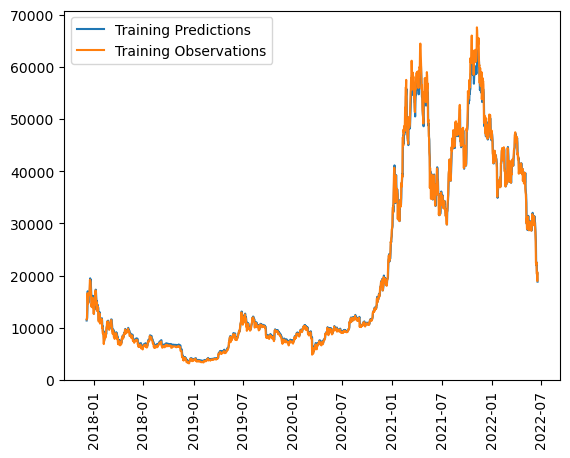

In [43]:
#Third model observations
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [44]:
score = model3.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0008512199856340885
Val MAE: 0.020103398710489273


8/8 [==============================] - 0s 3ms/step


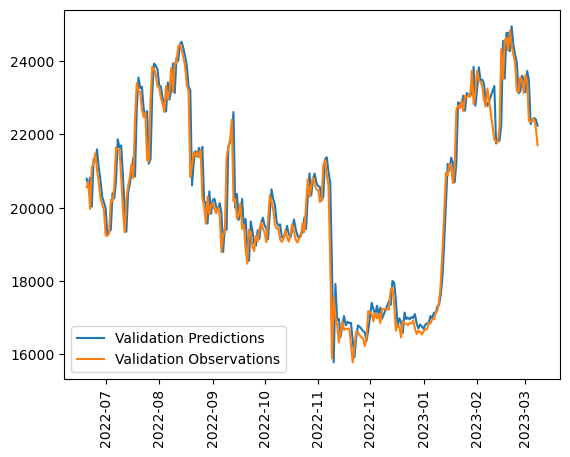

In [45]:
#Second model observations 
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [46]:
# Third Model MAE score
score = model3.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.00047470693243667483
Test MAE: 0.014822570607066154


7/7 [==============================] - 0s 3ms/step


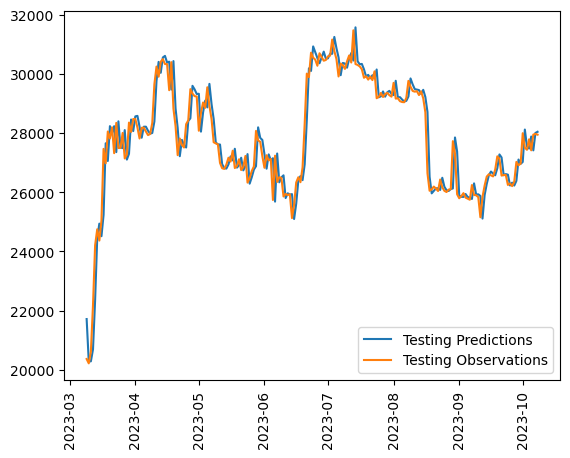

In [47]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions3))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [48]:
# R2 score for second model

print('R2 Score: ', r2_score(y_test2, test_predictions3))

R2 Score:  0.9029930964916043


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends

In [49]:
# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 7

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test2[-1]
current_reshape = current_batch.reshape((1, lookback, 1))
initial_date = dates_test2[-1]

# Generate predictions for 7 days
for i in range(prediction_range): # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        

    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, lookback, 1))

    
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# 'predictions' contains 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 21ms/step
[10.26284, 10.264623, 10.263712, 10.263432, 10.263533, 10.263603, 10.263608]
2023-10-09
2023-10-10
2023-10-11
2023-10-12
2023-10-13
2023-10-14
2023-10-15


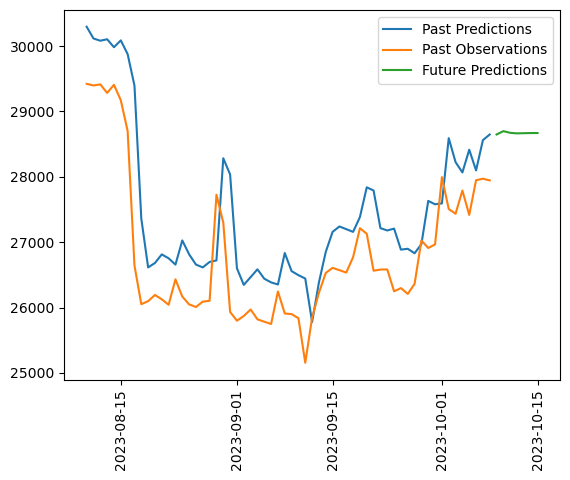

In [50]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test2[-60:], np.exp(test_predictions[-60:]))
plt.plot(dates_test2[-60:],np.exp(y_test2[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [51]:
# Export model1 to HDF5 file
model.save("H5_Files/btc_7_day_1.h5")

In [52]:
# Export model2 to HDF5 file
model2.save("H5_Files/btc_7_day_2.h5")

In [53]:
# Export model to HDF5 file
model3.save("H5_Files/btc_7_day_3.h5")

In [54]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates_test2[-90:], "observed":np.exp(y_test2[-90:]),\
                "model_1_predicted":np.exp(test_predictions[-90:]),\
                "model_2_predicted":np.exp(test_predictions2[-90:]),\
                "model_3_predicted":np.exp(test_predictions3[-90:])})
df.set_index('Date', inplace=True)

# df2 = pd.DataFrame({"Date": predicted_dates, "future_prediction":np.exp(predictions)})
# df2.set_index('Date', inplace=True)                   
                    
# past_future_df = pd.merge(df,df2, how='outer', left_index=True, right_index=True)


df


,observed,model_1_predicted,model_2_predicted,model_3_predicted
Date,,,,
2023-07-11,30621.0,31114.683594,31270.589844,30509.464844
2023-07-12,30382.0,31337.970703,31478.812500,30701.082031
2023-07-13,31471.0,31121.095703,31273.246094,30449.212891
2023-07-14,30331.0,32128.128906,32278.951172,31570.990234
2023-07-15,30301.0,31156.078125,31285.000000,30425.087891
...,...,...,...,...
2023-10-04,27790.0,28066.753906,28189.855469,27476.449219
2023-10-05,27417.0,28414.691406,28527.398438,27882.431641
2023-10-06,27948.0,28098.408203,28203.945312,27415.542969


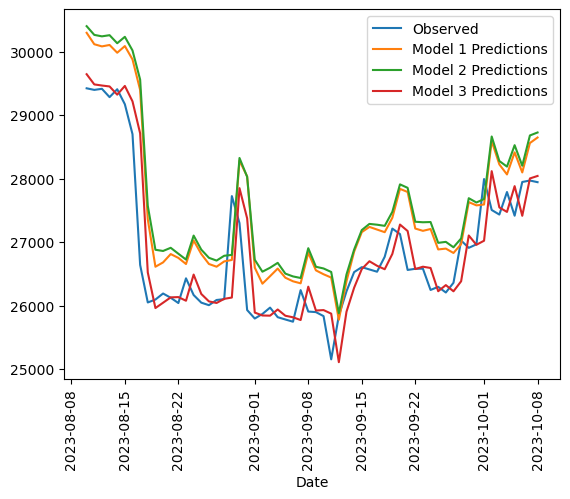

In [55]:
#Measuring each model's predictions against the test data
df[-60:].plot(use_index=True)
plt.xticks(rotation=90)

plt.legend(['Observed', 'Model 1 Predictions', 'Model 2 Predictions', \
            'Model 3 Predictions'])
plt.show()

In [56]:
#output prediction data to csv
df.to_csv('output/btc_predict.csv') 

In [57]:
#output original historical data to csv
data.to_csv('output/btc_lifetime.csv')

In [58]:
#Scores for each model

print('Model 1 R2 Score: ', r2_score(y_test1, test_predictions))
print('Model 2 R2 Score: ', r2_score(y_test2, test_predictions2))
print('Model 3 R2 Score: ', r2_score(y_test2, test_predictions3))

Model 1 R2 Score:  0.9699835159285334
Model 2 R2 Score:  0.761546486956576
Model 3 R2 Score:  0.9029930964916043
